In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
#read train image with CV
train_dir = '/data/fjsdata/ECG/MIT-BIH/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/fjsdata/ECG/MIT-BIH/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [13]:
#ATH model with Circle loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/qianjinhao/circle-loss        
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss
        
#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = CircleLoss().cuda() #define TripletLoss 
#train model
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 2.9730753Eopch:     1 mean_loss = 6.613775
 2000 / 2000 : loss = 6.6123589Eopch:     2 mean_loss = 5.034940
 2000 / 2000 : loss = 0.5436258Eopch:     3 mean_loss = 4.524892
 2000 / 2000 : loss = 12.040439Eopch:     4 mean_loss = 4.125866
 2000 / 2000 : loss = 0.7185888Eopch:     5 mean_loss = 3.834708
 2000 / 2000 : loss = 7.7534972Eopch:     6 mean_loss = 3.630361
 2000 / 2000 : loss = 1.7179011Eopch:     7 mean_loss = 3.504461
 2000 / 2000 : loss = 8.6781393Eopch:     8 mean_loss = 3.266231
 2000 / 2000 : loss = 2.7031469Eopch:     9 mean_loss = 3.216241
 2000 / 2000 : loss = 0.3677821Eopch:    10 mean_loss = 2.972215
best_loss = 2.972215
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.800640, mAP@10=0.782287, mRR@10=0.945994
Accuracy: 0.798400
[[12394   206  2208    46]
 [  535   128   276     5]
 [  251    84  3438    15]
 [  264     0   142     8]]
Specificity of N: 0.834388
Sensitivity of S: 0.135593
Sensitivity of V: 0.907603
Sensitivity of F: 0

In [11]:
#ATH model with Tripet loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.linear = nn.Linear(1*32*32, code_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x = self.linear(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
        
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])[0:4555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf)
#trQ_sf, trP_sf, trN_sf = onlineGenImgPairs() #sample 
#assert (trQ_sf.shape==trP_sf.shape)
#assert (trQ_sf.shape==trN_sf.shape)

#define model
model = ATHNet(code_size=36).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(20):#iteration
    losses = []
    #shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    #train_q = trQ_sf[shuffled_idx]
    #train_p = trP_sf[shuffled_idx]
    #train_n = trN_sf[shuffled_idx]
    trQ_sf, trP_sf, trN_sf = onlineGenImgPairs()
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(trQ_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(trP_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(trN_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash = model(P_batch.permute(0, 3, 1, 2))
        N_hash = model(N_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
criterion=criterion.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:#[5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #map_item_score = {}
        #for j, trVal in enumerate(trF):
        #    map_item_score[j] = pdist(np.vstack([teVal,trVal]),'hamming')
        #ranklist = heapq.nsmallest(topk, map_item_score, key=map_item_score.get)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(teF, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(trY)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(teY, y_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, y_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 1000 / 1000 : loss = 7.820362Eopch:     1 mean_loss = 3.363508
 1000 / 1000 : loss = 1.683783Eopch:     2 mean_loss = 2.114016
 1000 / 1000 : loss = 0.077225Eopch:     3 mean_loss = 1.906025
 1000 / 1000 : loss = 4.781073Eopch:     4 mean_loss = 1.730006
 1000 / 1000 : loss = 2.582189Eopch:     5 mean_loss = 1.622039
 1000 / 1000 : loss = 3.213246Eopch:     6 mean_loss = 1.582477
 1000 / 1000 : loss = 0.077375Eopch:     7 mean_loss = 1.498454
 1000 / 1000 : loss = 1.407424Eopch:     8 mean_loss = 1.430332
 1000 / 1000 : loss = 0.860806Eopch:     9 mean_loss = 1.326849
 1000 / 1000 : loss = 0.137802Eopch:    10 mean_loss = 1.322553
 1000 / 1000 : loss = 0.011024Eopch:    11 mean_loss = 1.228912
 1000 / 1000 : loss = 0.013151Eopch:    12 mean_loss = 1.258682
 1000 / 1000 : loss = 2.285988Eopch:    13 mean_loss = 1.250998
 1000 / 1000 : loss = 6.165338Eopch:    14 mean_loss = 1.211654
 1000 / 1000 : loss = 2.553177Eopch:    15 mean_loss = 1.085879
 1000 / 1000 : loss = 0.136082Eopch:    

Org data dimension is 1024.Embedded data dimension is 2


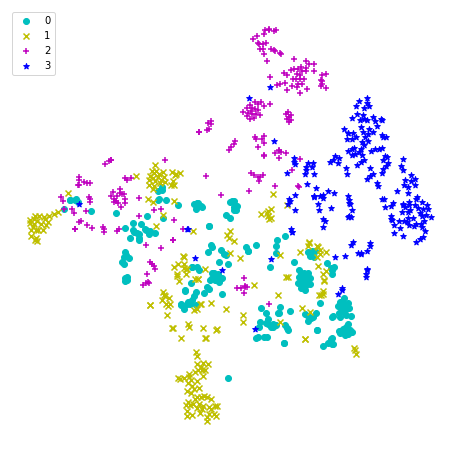

In [8]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()[0:200]
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()[0:200]
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()[0:200]
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()[0:200]
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [9]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'N', 1: 'S', 2:'V', 3:'F'}
#read image
root='/data/fjsdata/ECG/MIT-BIH/test/9994-2.png'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('MIT-BIH_cam.jpg', result)

0.979 -> V
0.020 -> S
0.001 -> N
0.000 -> F
output CAM.jpg for the top1 prediction: V


True

In [2]:
#Beats generation,
#we defined a single ECG beat image by centering the Q-wave peak signal while
#excluding the first and the last 20 ECG signals from the previous and afterward Q-wave peak signal
#https://github.com/MIT-LCP/wfdb-python/blob/master/demo.ipynb
#https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm
#http://www.tara.tcd.ie/bitstream/handle/2262/17623/automatic.pdf?sequence=1
def labeltotext(val):
    if val in ['N','L','R','e','j'] :
        return 0 #N
    elif val in ['A','a','J','S']:
        return 1 #S
    elif val in ['V','E']:
        return 2 #V
    elif val == 'F':
        return 3 #F
    else: 
        pass
    
rootdir = '/data/fjsdata/physionet/MIT-BIH/mitdb/'
right_len = 180 #right sample length around of peak value of QRS
left_len = 180 #left sample length around of peak value of QRS
#get trainset
trData = [] #[QRS value, label]
for bt in [101,106,108,109,112,114,115,116,118,119,122,124,201,203,205,207,208,209,215,220,223,230]:#22 records for train
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    trData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass
    
NOR = 14854 #normal samples    
trData = pd.DataFrame(np.array(trData))
NData =  trData[trData[1]==0].sample(n=NOR, random_state=1)
UNData = trData[trData[1]!=0]
trData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS1 = pd.DataFrame(trData[0].values.tolist())
y_DS1 = trData[1]
print('The shape of DS1 is: (%d,%d)'%(X_DS1.shape[0],X_DS1.shape[1]))
print(trData[1].value_counts())

#get testset
teData = [] #[QRS value, label]
for bt in [100,103,105,111,113,117,121,123,200,202,210,212,213,214,219,221,222,228,231,232,233,234]:#22 records for test
    file = os.path.join(rootdir,str(bt))
    try:
        annotation = wfdb.rdann(file, 'atr') 
        qrs_spl = annotation.sample #numpy.ndarray
        qrs_sym = annotation.symbol #list
        record = wfdb.rdrecord(file)
        signal = record.p_signal #numpy.ndarray
        max_len = record.sig_len #length of samples
        lead_name =  record.sig_name #names of lead channels,list
        for i in range(annotation.ann_len):
            if qrs_sym[i] in ['N','L','R','e','j','A','a','J','S','V','E','F']:#seven diseases samples
                pos = qrs_spl[i] #corresponding position of peak value of QRS
                if pos+right_len<=max_len and pos-left_len>=0:
                    max_idx = pos+right_len#np.min([max_len, pos+trunc_len])
                    min_idx = pos-left_len#np.max([0, pos-trunc_len])
                    QRS_value = signal[:,0][min_idx:max_idx] #only one lead
                    teData.append([QRS_value,labeltotext(qrs_sym[i])])
    except:
        pass

NOR = 14555 #normal samples    
teData = pd.DataFrame(np.array(teData))
NData =  teData[teData[1]==0].sample(n=NOR, random_state=1)
UNData = teData[teData[1]!=0]
teData = pd.concat([NData,UNData],axis=0).sample(frac=1) #shuffle
X_DS2 = pd.DataFrame(teData[0].values.tolist())
y_DS2 = teData[1]
print('The shape of DS2 is: (%d,%d)'%(X_DS2.shape[0],X_DS2.shape[1]))
print(teData[1].value_counts())

#model: faiss+index
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(right_len+left_len) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(X_DS2, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
#performance
scores, neighbors = gpu_index.search(np.ascontiguousarray(X_DS1, dtype=np.float32), k=1) #return top1
y_pred = []
for i in neighbors.flatten():
    y_pred.append(np.array(y_DS2)[i]) #label of top1
print ( 'Accuracy: %.6f'%accuracy_score(y_DS1.tolist(), y_pred))
#confusion matrix
labels = list(set(y_DS1))
cm = confusion_matrix(y_DS1.tolist(), y_pred, labels=labels ) #labels=['N','S','V','F']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

The shape of DS1 is: (20000,360)
0    14854
2     3788
1      944
3      414
Name: 1, dtype: int64
The shape of DS2 is: (20000,360)
0    14555
2     3220
1     1837
3      388
Name: 1, dtype: int64
Completed buliding index in 24 seconds
Accuracy: 0.807700
[[12810   419  1340   285]
 [  638   148   151     7]
 [  518    79  3158    33]
 [  277     1    98    38]]
Specificity: 0.862394
Sensitivity of S: 0.156780
Sensitivity of V: 0.833685
Sensitivity of F: 0.091787


In [3]:
#import ecg_plot#pip install ecg_plot, https://pypi.org/project/ecg-plot/
#from scipy.misc import electrocardiogram 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.electrocardiogram.html
fs = 360
for idx,row in X_DS2.iterrows():
    label = np.array(y_DS2)[idx]
    svpath = os.path.join('/data/fjsdata/ECG/MIT-BIH/train',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS2.shape[0]))
    sys.stdout.flush()
for idx,row in X_DS1.iterrows():
    label = np.array(y_DS1)[idx]
    svpath = os.path.join('/data/fjsdata/ECG/MIT-BIH/test',str(idx)+'-'+str(label))
    ecg = np.array(row)
    time = np.arange(ecg.size) / fs
    plt.figure(figsize=(5,3))
    plt.plot(time, ecg)
    plt.axis('off')
    plt.savefig(svpath,dpi=100) #(500=5*100,300=3*100)
    plt.close()
    sys.stdout.write('\r{} / {} '.format(idx,X_DS1.shape[0]))
    sys.stdout.flush()

19999 / 20000 